# How to run jobs in Raycluster using Jupyterhub?


In [5]:
!pip install ray[default]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 13.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 129.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.3/272.3 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 114

In [9]:
# We can get this address from the workder node of the RayCluster
# %env RAY_ADDRESS=cpu-raycluster-head-svc.default.svc.cluster.local:6379  #CPU Cluster
# GPU Cluster
%env RAY_ADDRESS=gpu-raycluster-head-svc.ray-gpu.svc.cluster.local:6379 

env: RAY_ADDRESS=gpu-raycluster-head-svc.ray-gpu.svc.cluster.local:6379


# Testing Code on CPU

In [10]:
# We need to specify the full path the source code since they need to run on the Raycluster node.
# This path does not exist on the jupyter node

# !ray job submit -- python  /data/src/05_dreambooth_finetuning/ray_test.py
# !ray job submit -- python  ray_test.py # without full path, default assumption is the home folder /home/ray and of course '/home/ray/ray_test.py' doesn't exist


!ray job submit -- python  $(pwd)/ray_data_test.py

Job submission server address: http://100.64.115.6:8265

-------------------------------------------------------
Job 'raysubmit_iDS2t9UEd5qrQ3Py' submitted successfully
-------------------------------------------------------

Next steps
  Query the logs of the job:
    ray job logs raysubmit_iDS2t9UEd5qrQ3Py
  Query the status of the job:
    ray job status raysubmit_iDS2t9UEd5qrQ3Py
  Request the job to be stopped:
    ray job stop raysubmit_iDS2t9UEd5qrQ3Py

Tailing logs until the job exits (disable with --no-wait):
2023-12-20 19:56:48,762	INFO worker.py:1405 -- Using address 100.64.115.6:6379 set in the environment variable RAY_ADDRESS
2023-12-20 19:56:48,763	INFO worker.py:1540 -- Connecting to existing Ray cluster at address: 100.64.115.6:6379...
2023-12-20 19:56:48,768	INFO worker.py:1715 -- Connected to Ray cluster. View the dashboard at 100.64.115.6:8265 
2023-12-20 19:56:50,111	INFO dataset.py:2488 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pa

In [28]:
!ray job stop raysubmit_Uw7YbSdb4C9EawDt

Job submission server address: http://100.64.115.6:8265
Attempting to stop job 'raysubmit_Uw7YbSdb4C9EawDt'
Waiting for job 'raysubmit_Uw7YbSdb4C9EawDt' to exit (disable with --no-wait):
Job has not exited yet. Status: RUNNING
Job has not exited yet. Status: RUNNING
Job has not exited yet. Status: RUNNING
Job 'raysubmit_Uw7YbSdb4C9EawDt' was stopped


# Step2: Submit the Dreambooth Training Job on GPUs

In [26]:
pwd

'/data/src/ray/doc/source/templates/05_dreambooth_finetuning'

In [29]:
!./step2_training.sh

+ pushd dreambooth
/data/src/ray/doc/source/templates/05_dreambooth_finetuning/dreambooth /data/src/ray/doc/source/templates/05_dreambooth_finetuning
+ export DATA_PREFIX=/data/tmp
+ DATA_PREFIX=/data/tmp
+ export ORIG_MODEL_NAME=CompVis/stable-diffusion-v1-4
+ ORIG_MODEL_NAME=CompVis/stable-diffusion-v1-4
+ export ORIG_MODEL_HASH=b95be7d6f134c3a9e62ee616f310733567f069ce
+ ORIG_MODEL_HASH=b95be7d6f134c3a9e62ee616f310733567f069ce
+ export ORIG_MODEL_DIR=/data/tmp/model-orig
+ ORIG_MODEL_DIR=/data/tmp/model-orig
+ export ORIG_MODEL_PATH=/data/tmp/model-orig/models--CompVis--stable-diffusion-v1-4/snapshots/b95be7d6f134c3a9e62ee616f310733567f069ce
+ ORIG_MODEL_PATH=/data/tmp/model-orig/models--CompVis--stable-diffusion-v1-4/snapshots/b95be7d6f134c3a9e62ee616f310733567f069ce
+ export TUNED_MODEL_DIR=/data/tmp/model-tuned
+ TUNED_MODEL_DIR=/data/tmp/model-tuned
+ export IMAGES_REG_DIR=/data/tmp/images-reg
+ IMAGES_REG_DIR=/data/tmp/images-reg
+ export IMAGES_OWN_DIR=/data/tmp/images-own
+ IM

In [3]:
!ray job stop raysubmit_qN7q59HQDR2R2DEd

Job submission server address: http://100.64.179.194:8265
Attempting to stop job 'raysubmit_qN7q59HQDR2R2DEd'
Waiting for job 'raysubmit_qN7q59HQDR2R2DEd' to exit (disable with --no-wait):
Job has not exited yet. Status: RUNNING
Job has not exited yet. Status: RUNNING
Job has not exited yet. Status: RUNNING
Job 'raysubmit_qN7q59HQDR2R2DEd' was stopped


# Step 3: Interference


In [30]:
! ./step3_inference.sh

+ pushd dreambooth
/data/src/ray/doc/source/templates/05_dreambooth_finetuning/dreambooth /data/src/ray/doc/source/templates/05_dreambooth_finetuning
+ export DATA_PREFIX=/data/tmp
+ DATA_PREFIX=/data/tmp
+ export ORIG_MODEL_NAME=CompVis/stable-diffusion-v1-4
+ ORIG_MODEL_NAME=CompVis/stable-diffusion-v1-4
+ export ORIG_MODEL_HASH=b95be7d6f134c3a9e62ee616f310733567f069ce
+ ORIG_MODEL_HASH=b95be7d6f134c3a9e62ee616f310733567f069ce
+ export ORIG_MODEL_DIR=/data/tmp/model-orig
+ ORIG_MODEL_DIR=/data/tmp/model-orig
+ export ORIG_MODEL_PATH=/data/tmp/model-orig/models--CompVis--stable-diffusion-v1-4/snapshots/b95be7d6f134c3a9e62ee616f310733567f069ce
+ ORIG_MODEL_PATH=/data/tmp/model-orig/models--CompVis--stable-diffusion-v1-4/snapshots/b95be7d6f134c3a9e62ee616f310733567f069ce
+ export TUNED_MODEL_DIR=/data/tmp/model-tuned
+ TUNED_MODEL_DIR=/data/tmp/model-tuned
+ export IMAGES_REG_DIR=/data/tmp/images-reg
+ IMAGES_REG_DIR=/data/tmp/images-reg
+ export IMAGES_OWN_DIR=/data/tmp/images-own
+ IM

### Example output image

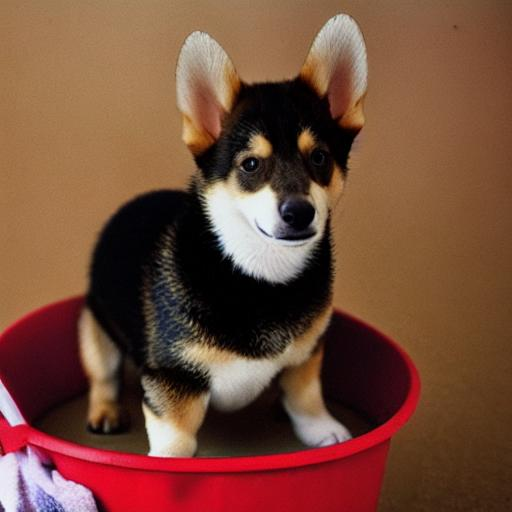

In [31]:
from IPython.display import Image
Image("/data/tmp/artifacts/example_out.jpg")